# GP Demo
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thodson-usgs/workflow-hodson-2024-loadest-gp/blob/master/demo-loadest-gp.ipynb)

The concentration is modeled is a function of time $t$ and the log flow $q$
$$
f(t, q) \sim \mathcal{GP}_{\text{trend}}(0, k_1(t, t')) 
          + \mathcal{GP}_{\text{seasonal}}(0, k_2(t, t'))
          + \mathcal{GP}_{\text{short}}(0, k_3(t, t'))
          + \mathcal{GP}_{\text{flow}}(0, k_3(q, q'))
          + \epsilon
$$

In [134]:
#setup colab
import os

if os.getenv("COLAB_RELEASE_TAG"):
   print("Running in Colab")
   os.system('pip install pymc dataretrieval')
   os.system('MKL_THREADING_LAYER=GNU')
    
else:
   print("NOT in Colab")

NOT in Colab


In [135]:
# Gather discharge data:
site = "01491000" #Choptank River at Greensboro, MD
parameter_cd = "00631" #5 digit USGS code
start = "1979-10-01"
end = "2011-09-30"

## Another example
site = "12413470"
parameter_cd = "00665"
parameter_cd = "00631"
start= "1988-10-01" 
end= "2021-09-30" 

from dataretrieval import nwis
import pandas as pd
import numpy as np

daily, _ = nwis.get_dv(sites=site, start=start, end=end, parameterCd="00060")
samples, _ = nwis.get_qwdata(sites=site, start=start, end=end, parameterCd=parameter_cd)

/home/thodson/miniforge3/envs/pymc/lib/python3.11/site-packages/dataretrieval/nwis.py:180: UserWarning: WARNING: Starting in March 2024, the NWIS qw data endpoint is retiring and no longer receives updates. For more information, refer to https://waterdata.usgs.gov.nwis/qwdata and https://doi-usgs.github.io/dataRetrieval/articles/Status.html or email CompTools@usgs.gov.
  warnings.warn(('WARNING: Starting in March 2024, the NWIS qw data endpoint is '


In [136]:
# preprocess
daily["flow"] = daily["00060_Mean"]
daily = daily[["flow"]]

#daily["flow"] = daily["flow"] * 0.028316831998814504 # Convert to cubic meters per second
# truncate zero flows

In [137]:
import xarray as xr
df = daily.reset_index()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
ds = xr.Dataset.from_dataframe(df)
ds

<xarray.Dataset> Size: 193kB
Dimensions:   (datetime: 12053)
Coordinates:
  * datetime  (datetime) object 96kB 591667200000000000 ... 1632960000000000000
Data variables:
    flow      (datetime) float64 96kB 76.0 73.0 73.0 75.0 ... 104.0 118.0 102.0

In [138]:
pcode = "p" + parameter_cd
samples["concentration"] = samples[pcode]
samples = samples[["concentration"]]
samples['concentration'] = samples['concentration'].str.extract('(\d+.\d+)', expand=False).astype(float)

# aggregate samples to daily
samples = samples['concentration'].groupby(samples.index.date).mean()
#samples = samples.resample('D').mean()
# convert samples.index to datetime index
samples.index = pd.to_datetime(samples.index, utc=True)

samples = pd.merge(samples, daily, left_index=True, right_index=True)

In [139]:
def decimal_year(time):
    days_in_year = 365 + time.is_leap_year
    day_of_year = time.day_of_year
    year = time.year
    return year + day_of_year / days_in_year

In [140]:
daily['decimal_year'] = decimal_year(daily.index)
samples['decimal_year'] = decimal_year(samples.index)

In [141]:
from pandas import to_datetime

In [142]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

zero_clip = lambda a: np.clip(a, a_min=0, a_max=None)
log_clip = lambda a: np.clip(a, a_min=0.1, a_max=None)

flow_pipeline = Pipeline(
    steps=[
        ("clip", FunctionTransformer(func=log_clip)),
        ("log", FunctionTransformer(func=np.log, inverse_func=np.exp)),
        ("scaler", StandardScaler()),
    ]
)


target_pipeline = Pipeline(
    steps=[
        ("clip", FunctionTransformer(func=zero_clip, inverse_func=zero_clip)),
        ("log", FunctionTransformer(func=np.log, inverse_func=np.exp)),
        ("scaler", StandardScaler()),
    ]
)

target_cov_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler(with_mean=False)),
        ("square", FunctionTransformer(func=np.square, inverse_func=np.sqrt)),
    ]
)

flow_pipeline.fit(samples['flow'].values.reshape(-1, 1))
target_pipeline.fit(samples['concentration'].values.reshape(-1, 1))
target_cov_pipeline.fit(samples['concentration'].values.reshape(-1, 1))

Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('square',
                 FunctionTransformer(func=<ufunc 'square'>,
                                     inverse_func=<ufunc 'sqrt'>))])

In [143]:
# build design matrix

flow_z = flow_pipeline.transform(samples['flow'].values.reshape(-1, 1))
#flow_test = flow_pipeline.inverse_transform(flow_z)
target_z = target_pipeline.transform(samples['concentration'].values.reshape(-1, 1))

time = samples['decimal_year']

X = np.c_[flow_z, time]
y = target_z.flatten()

In [144]:
Xnew = np.c_[
    flow_pipeline.transform(daily['flow'].values.reshape(-1, 1)),
    daily['decimal_year'],
]

In [145]:
import pymc as pm

with pm.Model() as model:
    # seasonal trend
    eta_per = pm.HalfNormal("eta_per", sigma=1, initval=1) # was 2
    ls_pdecay = pm.LogNormal("ls_pdecay", mu=2, sigma=1)
    # https://peterroelants.github.io/posts/gaussian-process-kernels/
    period = pm.Normal("period", mu=1, sigma=0.05)
    ls_psmooth = pm.LogNormal("ls_psmooth", mu=1, sigma=1) #14 sec at 0,0.5
    
    cov_seasonal = (
        eta_per**2 * pm.gp.cov.Periodic(2, period, ls_psmooth, active_dims=[1]) \
        #* pm.gp.cov.ExpQuad(2, ls=ls_pdecay, active_dims=[1])
        * pm.gp.cov.Matern52(2, ls_pdecay, active_dims=[1])
    )
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)

    # longterm trend
    #eta_trend =  pm.HalfNormal("eta_trend", sigma=1) # was 2
    eta_trend = pm.Exponential("eta_trend", scale=1.5) # Exponential might to limit outliers dictating a trend
    ls_trend = pm.LogNormal("ls_trend", mu=2, sigma=1)
    cov_trend = eta_trend**2 * pm.gp.cov.ExpQuad(2, ls_trend, active_dims=[1])
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)
    

    # flow trend
    eta_flow = pm.HalfNormal("eta_flow", sigma=2) # was 2
    ls_flow = pm.LogNormal("ls_flow", mu=-1.1, sigma=1, initval=0.5)
    cov_flow = eta_flow**2 * pm.gp.cov.ExpQuad(2, ls=ls_flow, active_dims=[0])
    gp_flow = pm.gp.Marginal(cov_func=cov_flow)
    
    

    # noise model
    eta_noise = pm.Exponential("eta_noise", scale=0.2) # 0.5 worked good for chop: 720 and 1:17
    ls_noise = pm.LogNormal("ls_noise", mu=-1.1, sigma=1, initval=0.1)
    cov_noise = eta_noise**2 * pm.gp.cov.ExpQuad(2, ls_noise, active_dims=[1]) #eta=0.57
    gp_noise = pm.gp.Marginal(cov_func=cov_noise)


    gp = gp_trend + gp_seasonal  + gp_noise + gp_flow
    
    # noise_model
    cov_measure = pm.gp.cov.WhiteNoise(0.1) # 40 seconds with  eta_noise = 0.1
    
    y_ = gp.marginal_likelihood("y", X=X, y=y, sigma=cov_measure)

In [146]:
with model:
    %time mp = pm.find_MAP(method="BFGS") #750 at 2 min #at eta_noise 0.1 was 1.37 and 725

Output()

CPU times: user 1min 21s, sys: 1.61 s, total: 1min 23s
Wall time: 11.4 s


In [133]:
mp

{'eta_per_log__': array(-0.27585314),
 'ls_pdecay_log__': array(1.38993811),
 'period': array(1.03907807),
 'ls_psmooth_log__': array(-0.00653584),
 'eta_trend_log__': array(-1.57946003),
 'ls_trend_log__': array(2.18323234),
 'eta_flow_log__': array(-0.61745564),
 'ls_flow_log__': array(-0.94831929),
 'eta_noise_log__': array(-0.26957525),
 'ls_noise_log__': array(-4.53262727),
 'eta_per': array(0.75892438),
 'ls_pdecay': array(4.0146016),
 'ls_psmooth': array(0.99348548),
 'eta_trend': array(0.20608635),
 'ls_trend': array(8.87494682),
 'eta_flow': array(0.5393149),
 'ls_flow': array(0.38739157),
 'eta_noise': array(0.76370381),
 'ls_noise': array(0.01075239)}

In [122]:
with model:
    #f_pred = gp.conditional("f_pred", Xnew=Xnew)
    mu, cov = gp.predict(Xnew, point=mp, diag=True, pred_noise=True)

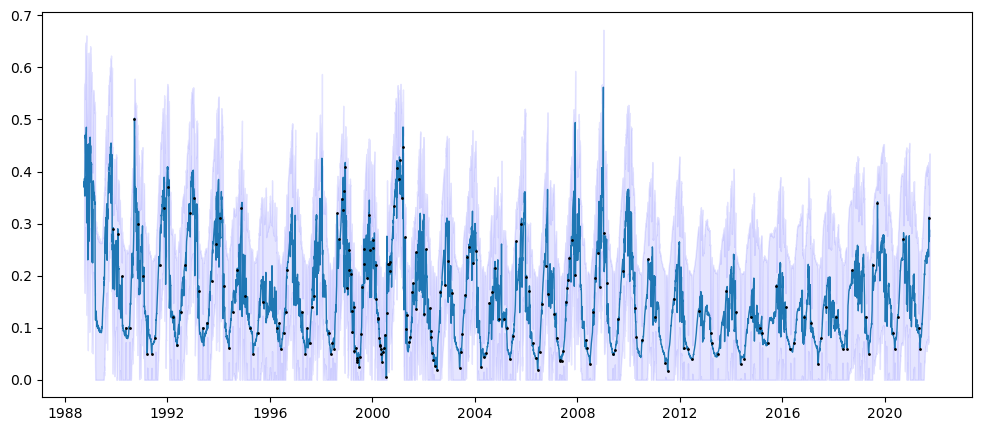

In [123]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

#ax.plot(daily.index, mu, lw=3) #np.exp(mu)
#ax.plot(samples.index, y, "ok")
c = target_pipeline.inverse_transform(mu.reshape(-1,1)).flatten()
ci = target_cov_pipeline.inverse_transform(cov.reshape(-1,1)).flatten() * 1.96

#ci = np.sqrt(cov) * 1.96
ax.fill_between(daily.index, zero_clip(c-ci), c+ci, color='b', alpha=.1)

ax.plot(daily.index, c, lw=1) #np.exp(mu)
ax.plot(samples.index, samples['concentration'], "ok", ms=1)

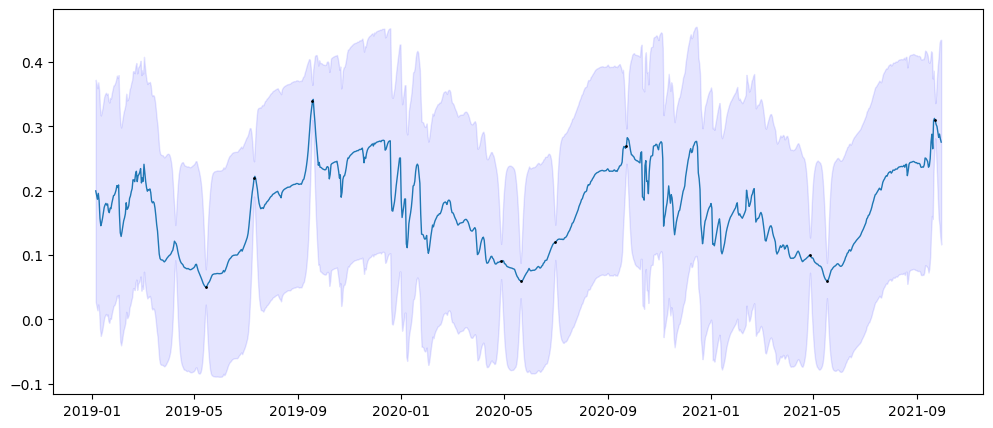

In [124]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

#n = 200; s = 10
n = 1000; s = 10
c = target_pipeline.inverse_transform(mu.reshape(-1,1)).flatten()
ci = target_cov_pipeline.inverse_transform(cov.reshape(-1,1)).flatten() * 1.96
ci = ci[-n:]
c = c[-n:]


ax.fill_between(daily.index[-n:], c-ci, c+ci, color='b', alpha=.1)
ax.plot(daily.index[-n:], c, lw=1) #np.exp(mu)
ax.plot(samples.index[-s:], samples['concentration'][-s:], "ok", ms=1)

In [125]:
# remove specific components
mp2 = mp.copy()
#mp2['eta_per']=0
#mp2['eta_trend']=0
#mp2['eta_flow']=0
#mp2['eta_noise']=0

In [126]:
# compute grid bounds for contour plot
q_min = samples['flow'].min().reshape(-1,1)
q_max = samples['flow'].max().reshape(-1,1)

x1_min = flow_pipeline.transform(np.array(q_min)).squeeze()
x1_max = flow_pipeline.transform(np.array(q_max)).squeeze()
x1_min

array(-1.54956878)

In [127]:
#q_max = 20
#q_min = 0.5
#x1_min = flow_pipeline.transform(np.array(q_min).reshape(-1,1)).squeeze()
#x1_max = flow_pipeline.transform(np.array(q_max).reshape(-1,1)).squeeze()

In [94]:
## Choptank example
#n1, n2 = (18, 30*12)
#x1 = np.linspace(x1_min, x1_max, n1)
#x2 = np.linspace(1980, 2010, n2)
#
## make cartesian grid out of each dimension x1 and x2
#X_grid = pm.math.cartesian(x1[:, None], x2[:, None])

In [128]:
# Bobs example
n1, n2 = (18, 32*12)
x1 = np.linspace(x1_min, x1_max, n1)
x2 = np.linspace(1990, 2022, n2)

# make cartesian grid out of each dimension x1 and x2
X_grid = pm.math.cartesian(x1[:, None], x2[:, None])

In [129]:
with model:
    #f_grid = gp.conditional("f_grid", Xnew=X_grid)
    mu, cov = gp.predict(X_grid, point=mp2, pred_noise=False)

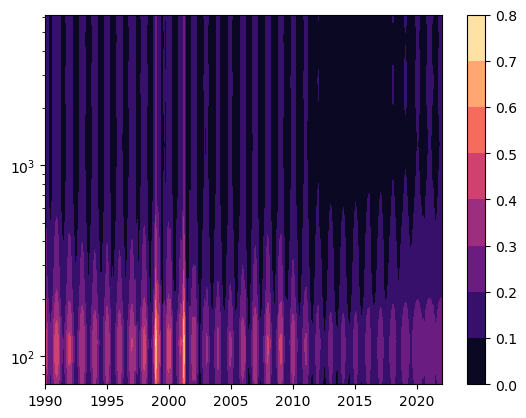

In [130]:
c = target_pipeline.inverse_transform(mu.reshape(-1,1))
c = c.reshape(n1, n2)
q = (flow_pipeline.inverse_transform(x1.reshape(-1,1)))

fig, ax = plt.subplots()
ax.set_yscale('log')
X2, X1 = np.meshgrid(x2, q)
cs = ax.contourf(X2, X1, c, cmap='magma')

cbar = fig.colorbar(cs)

# TESTING .conditional

In [106]:
with model:
    #f_pred = gp.conditional("f_pred", Xnew=Xnew)
    mu, cov = gp.predict(Xnew, point=mp, diag=False, pred_noise=False)

In [35]:
cov_year = cov[-365:,-365:] # can't simulate the whole thing so let's try one year at a time
mu_year = mu[-365:]

#sim = pm.MvNormal.dist(mu_year, cov_year)
#from numpy import random
rng = np.random.default_rng()
sim = rng.multivariate_normal(mu, cov, size=1000, method='cholesky')


c = target_pipeline.inverse_transform(sim)
annual = c.sum(axis=1)

(array([  1.,   3.,   2.,  13.,  23.,  40.,  52.,  92., 106., 118., 112.,
        128., 104.,  76.,  54.,  41.,  18.,   8.,   6.,   3.]),
 array([ 941.3631237 ,  945.62430961,  949.88549553,  954.14668145,
         958.40786737,  962.66905328,  966.9302392 ,  971.19142512,
         975.45261103,  979.71379695,  983.97498287,  988.23616879,
         992.4973547 ,  996.75854062, 1001.01972654, 1005.28091245,
        1009.54209837, 1013.80328429, 1018.06447021, 1022.32565612,
        1026.58684204]),
 <BarContainer object of 20 artists>)

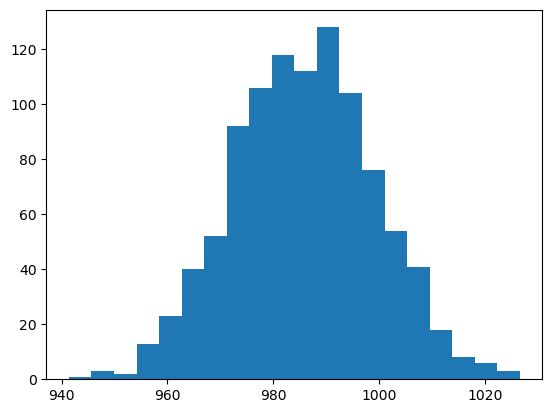

In [36]:
c = target_pipeline.inverse_transform(sim)
plt.hist(annual, bins=20)

In [112]:
# now let's ignore the covariance
with model:
    #f_pred = gp.conditional("f_pred", Xnew=Xnew)
    mu, cov = gp.predict(Xnew, point=mp, diag=True, pred_noise=False)

In [133]:
cov_year.shape

(365, 365)

In [135]:
cov_year = cov[-365:] # can't simulate the whole thing so let's try one year at a time
mu_year = mu[-365:]
cov_year = np.diag(cov_year)

#sim = random.normal(mu_year, cov_year, size=100)
#c = target_pipeline.inverse_transform(sim)
#annual = c.sum(axis=1)
sim = random.multivariate_normal(mu_year, cov_year, size=1000)
c = target_pipeline.inverse_transform(sim)
annual = c.sum(axis=1)

(array([  4.,   2.,   6.,  11.,  36.,  40.,  62., 109.,  91., 131., 128.,
        112., 100.,  65.,  50.,  26.,  14.,   6.,   5.,   2.]),
 array([68.50444048, 68.79148135, 69.07852222, 69.36556309, 69.65260396,
        69.93964483, 70.2266857 , 70.51372657, 70.80076744, 71.08780831,
        71.37484918, 71.66189005, 71.94893092, 72.23597179, 72.52301266,
        72.81005353, 73.0970944 , 73.38413527, 73.67117614, 73.95821701,
        74.24525788]),
 <BarContainer object of 20 artists>)

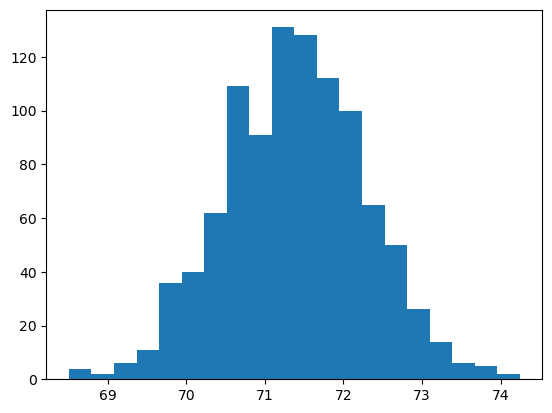

In [136]:
c = target_pipeline.inverse_transform(sim)
plt.hist(annual, bins=20)

In [24]:
with model:
    # https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Marginal.html
    #marginal_post = pm.sample(500, tune=2000, nuts_sampler="numpyro", chains=1) #NEEDS A GPU
    %timeit test = pm.fit()

Output()

Interrupted at 1,724 [17%]: Average Loss = 3,604.8


Output()

Interrupted at 76 [0%]: Average Loss = 4,173.1

KeyboardInterrupt



In [25]:
samples.min()

concentration       0.005000
flow               71.000000
decimal_year     1989.887671
dtype: float64

In [30]:

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", Xnew)

In [37]:
marginal_post.sel(draw=slice(0, 20))

NameError: name 'marginal_post' is not defined

In [36]:
with model:
    pred_samples = pm.sample_posterior_predictive(
        marginal_post.sel(draw=slice(0, 20)), var_names=["f_pred"]
    )d"]
    )

SyntaxError: unterminated string literal (detected at line 4) (655374434.py, line 4)

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

f_pred_samples = az.extract(pred_samples, group="posterior_predictive", var_names=["f_pred"])
plot_gp_dist(ax, samples=f_pred_samples.T, x=X_new)

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();